### **For this assignment the only permitted libraries to use are Numpy, Scipy, MatplotLib and Pandas! All four have been imported for you in this Notebook.**

In [4]:
import random

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [5]:
train_file_path = 'lab1_train.csv'

train_data = pd.read_csv(train_file_path, delimiter=',', skipinitialspace= True)

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

test_file_path = 'lab1_test.csv'

test_data = pd.read_csv(test_file_path, delimiter=',', skipinitialspace= True)

# Convert Timestamp column to datetime
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

In [ ]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()

# visualize_sensor_data(train_data, window=(0, 1000), sensors=['FIT101'])
# visualize_sensor_data(train_data, window=(0, 1000),sensors=['LIT101'])
# visualize_sensor_data(train_data)

# Familiarization 
### What types of signals are there?
All of them seem to be semi-continuous and clearly not random, which is to be expected with time series, as previous signals will likely not vary much from one point to another. This can be seen when analysing the signals with a very small window. There are also some signals which seem to be more "constant", one of them exhibiting one rather discrete "jump".

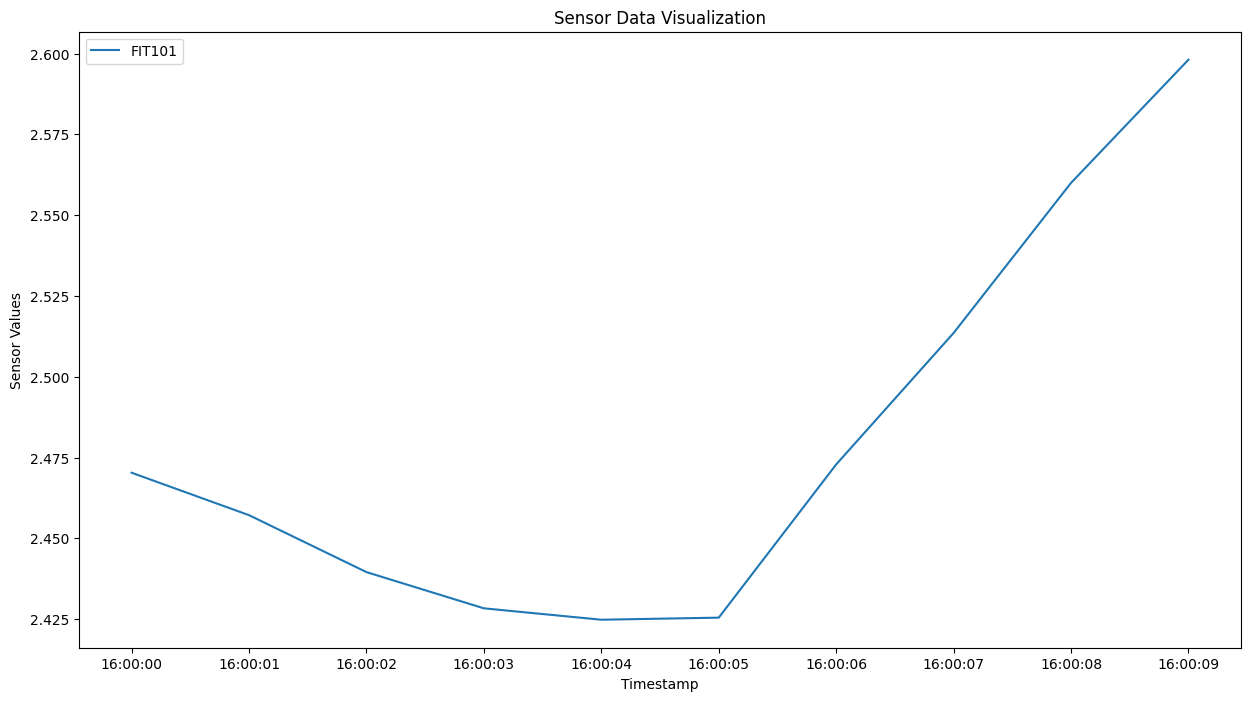

In [4]:
visualize_sensor_data(train_data, window=(0, 10), sensors=['FIT101'])

There are also some signals which seem to be more "constant", one of them also exhibiting one rather discrete "jump".

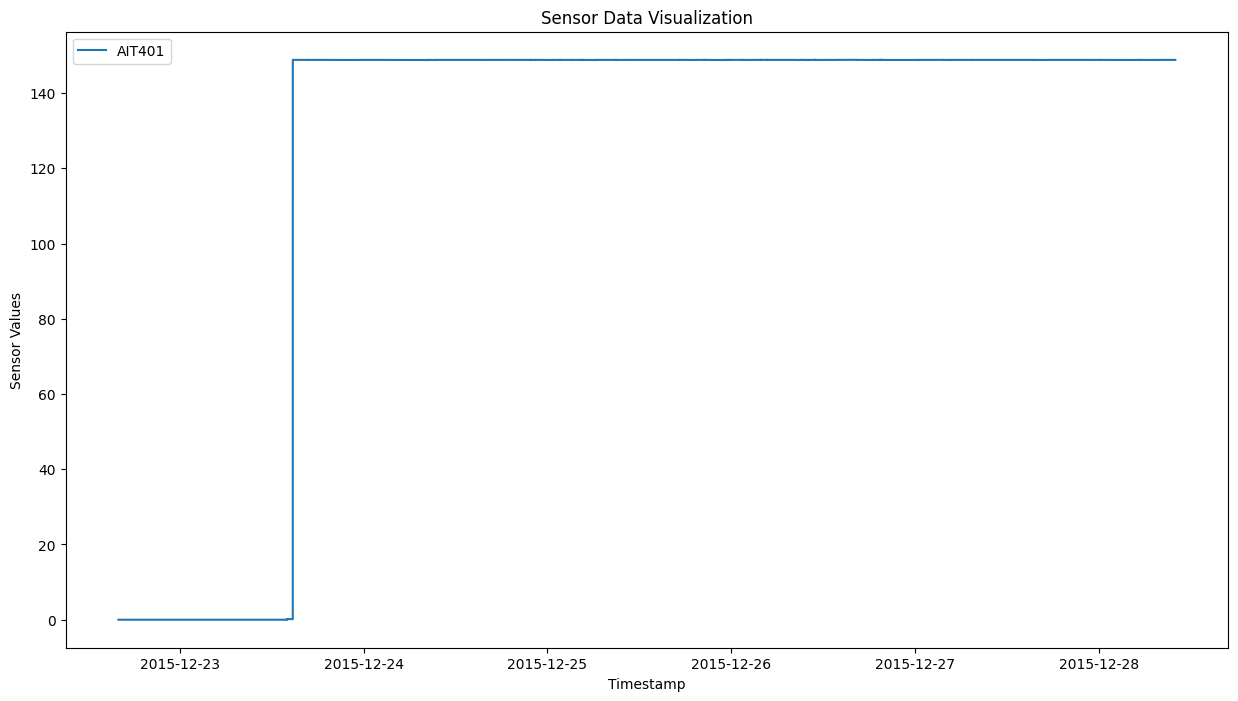

In [5]:
visualize_sensor_data(train_data, sensors=['AIT401'])

### Are the signals correlated? Do they show cyclic behavior?
Some of the signals can be seen as correlated, showing, for example, some unusual behaviour - compared to the rest, both around the (temporal) beginning of the dataset (which can be associated with the system booting up, and also at a point in time between 2015-12-23 and 2015-12-24. Moreover, cyclic behaviour is clearly shown for almost all the signals.

In [6]:
# visualize_sensor_data(train_data) # takes a bit to run

# DTW-based anomaly detection
We will be focusing on signal `LIT201`:

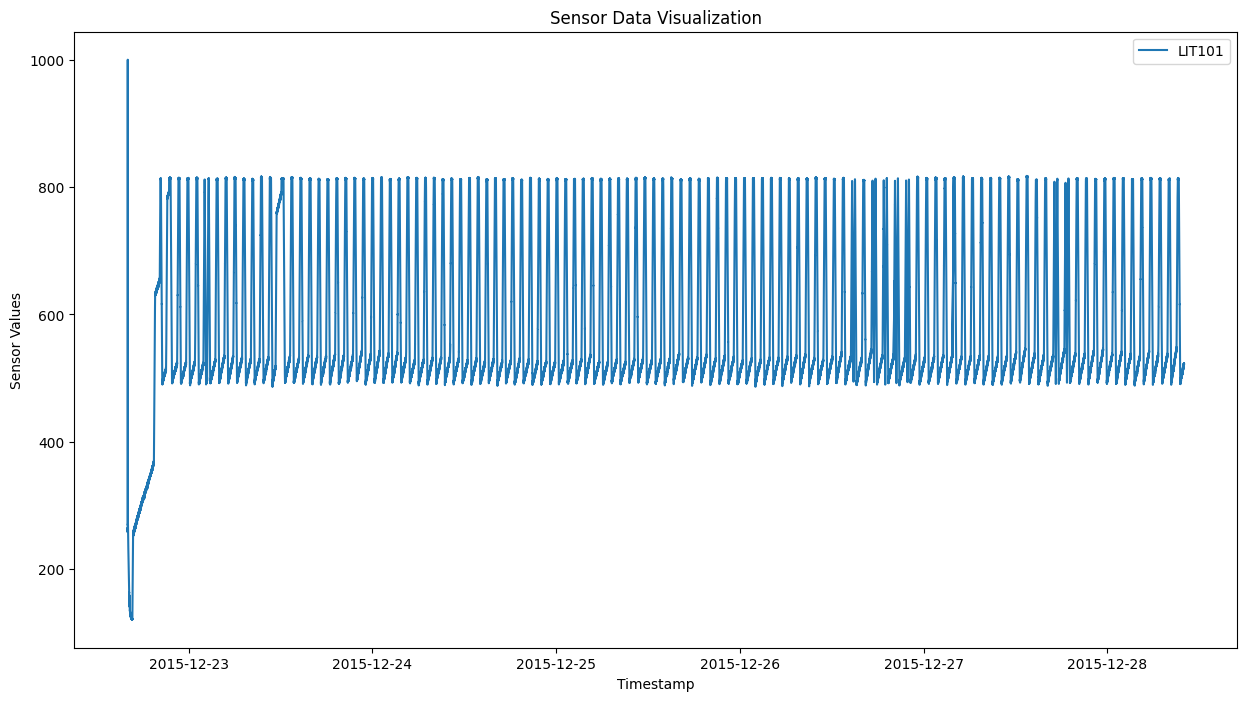

In [38]:
visualize_sensor_data(train_data, sensors=['LIT101'])

Since we will consider the first part of the timeseries as a period for booting up the sequence, we will exclude it from out training data (by finding the index of the row at which the "boot" sequence has ended ~ through experiment found around 17000):

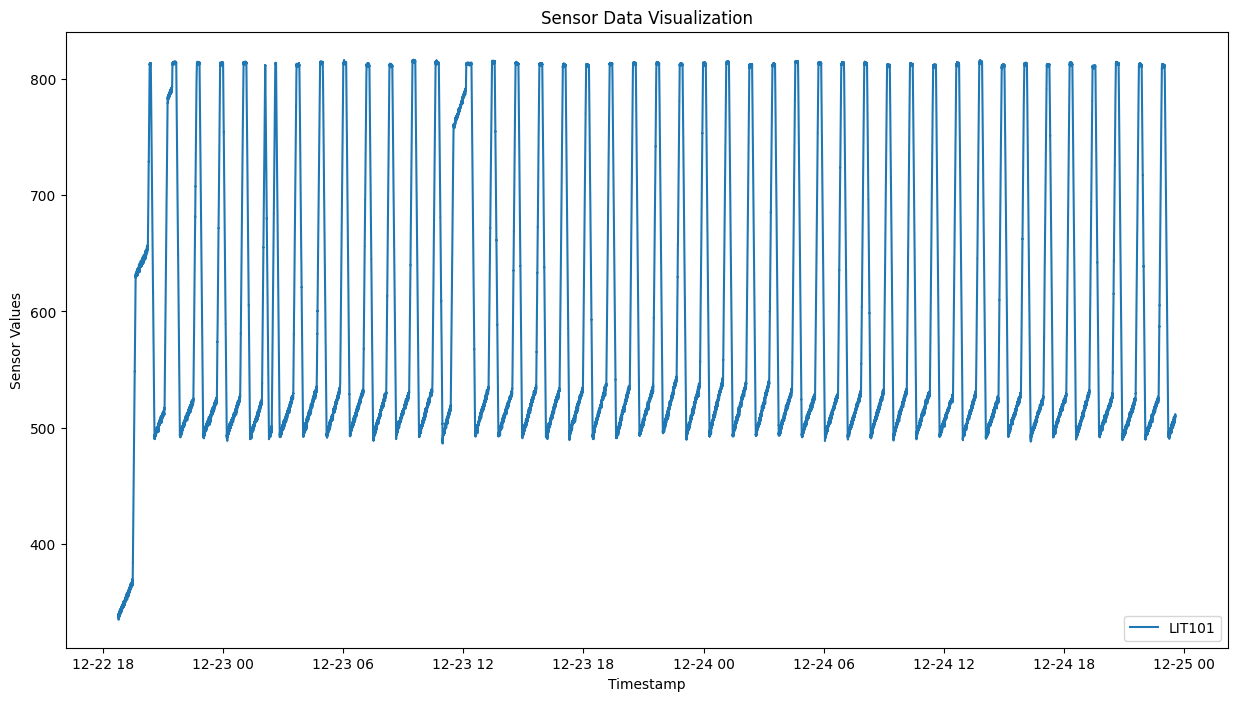

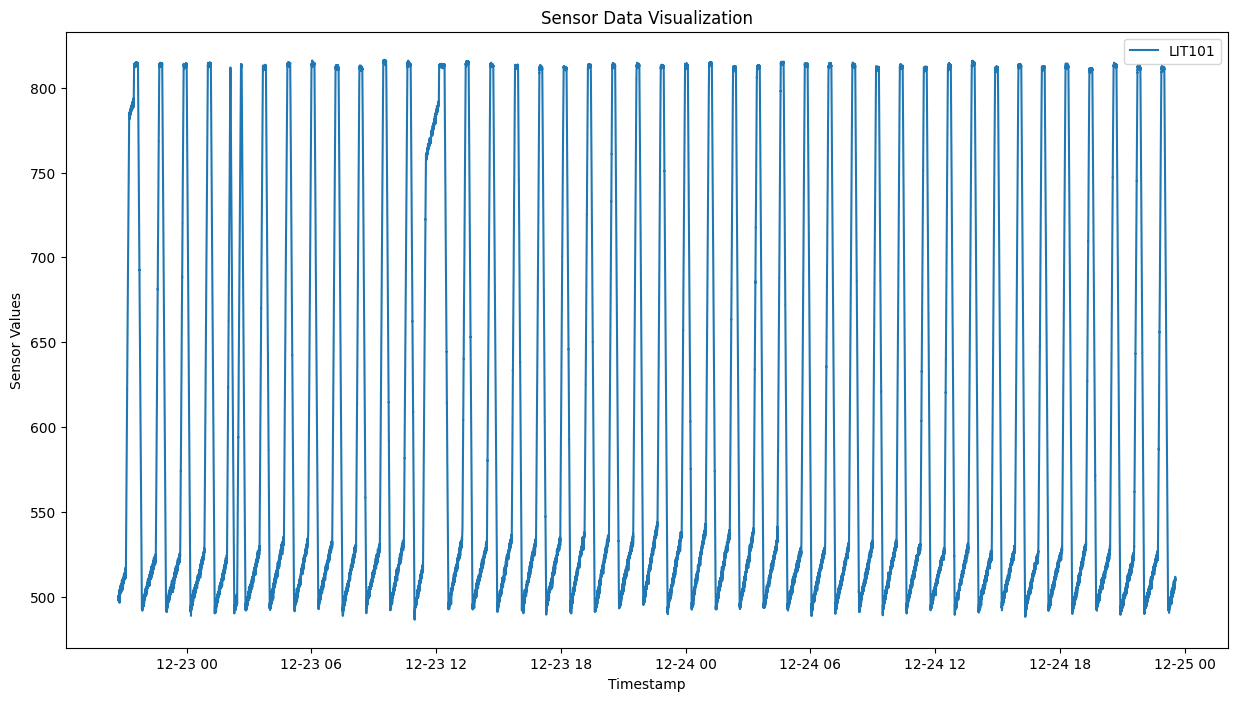

In [8]:
visualize_sensor_data(train_data, sensors=['LIT101'], window=(10000,200000))
visualize_sensor_data(train_data, sensors=['LIT101'], window=(17000,200000))

One could also exclude the first part of the test dataset as well based on a similar reasoning, however we will not as the timestamp intervals of the test and training set do not overlap, thus we can't "excuse" any abnormal behaviour in the beginning of the test set.

In [9]:
sensor_name = 'LIT101'
trimmed_train_data = train_data[17000:][['Timestamp',sensor_name]]
# trimmed_test_data = test_data[17000:][['Timestamp',sensor_name]]
trimmed_test_data = test_data[['Timestamp',sensor_name]]

First we define the general dtw algorithm that we will be using (based on the implementation from Weblab). This is standard DTW, not Fast DTW, as we have seen that the latter doesn't provide much of a speedup, at least for our settings.

In [10]:
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size
    matrix = np.zeros((n+1,m+1)) # we are filling the matrix with actual distance variables from 1 to n, respectively from 1 to m
    for i in range(n):
        for j in range(m):
            matrix[i+1,j+1]=(a[i]-b[j])**2
    for i in range(0,m+1):
        matrix[0,i]=1000000000
    for i in range(1,n+1):
        matrix[i,0]=1000000000
    for i in range(1,n+1):
        for j in range( 1,m+1):
            if i+j!=2:
                matrix[i,j]=matrix[i,j]+min(matrix[i-1,j],matrix[i-1,j-1],matrix[i,j-1])
    return matrix[n,m]**0.5

The general approach of the algorithm first defines the parameters that are going to be used. The representative windows will be randomly chosen from our train set (where all points are labeled as Normal). Even though there might still be anomalous points / windows in the train dataset, there is a very low possibility that those will actually be included in our representative window. However, suffering from the curse of dimensionality, a high number of representative windows increases the chances of erroneous windows to be included in the representative set.

The window size is chosen such that approximately to "standard" bumps are included, and the jump size ensures that there is some overlap between windows, in order to account for synchronization issues between test and train data.

In [11]:
window_size = 6000
jump_size = 3000
number_of_representative_windows = 20
sub_sampling_size = 100

data_windows = np.lib.stride_tricks.sliding_window_view(trimmed_train_data[sensor_name],(window_size,))
total_windows = data_windows.shape[0]
representative_windows = random.choices(data_windows, k=number_of_representative_windows)

We will first compute the residuals for the train data. Note that the `sub_sampling_size` dramatically reduces run time, and the idea behind it is that points do not differ drastically on small intervals, thus it we still maintain accuracy if we just take points 100 apart.

In [12]:
data_windows = np.lib.stride_tricks.sliding_window_view(trimmed_train_data[sensor_name],(window_size,))
train_distances = []
for window in data_windows[::jump_size]:
    minDist = 1e9
    for representative_window in representative_windows:
        dist = dynamic_time_warping(window[::sub_sampling_size], representative_window[::sub_sampling_size])
        if dist < minDist and dist != 0:
            minDist = dist
            
    train_distances.append(minDist)

Let's plot them, along with some statistics:

Average: 78.00046047989915
Standard deviation: 61.71322006106573


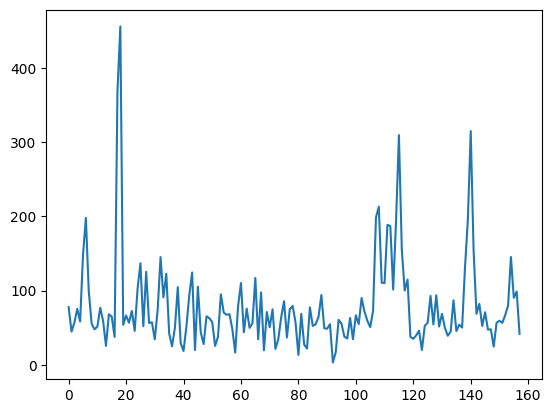

In [13]:
plt.plot(train_distances)
train_average = np.mean(train_distances)
train_std = np.std(train_distances)
print(f"Average: {train_average}")
print(f"Standard deviation: {train_std}")

In order to really avoid false alarms, we will set the threshold to `k * train_std + train_average`, where k is a parameter that could be tuned. The higher the k, the smaller the chance of a false alarm.

Using DTW in this manner we expect to be more efficient at finding collective anomalies. We can clearly see how this reflects in our findings. The absence of cyclic for the continuous interval signals right after 31/12/2015 is clearly detected. In this context, some contextual anomalies are also detected.

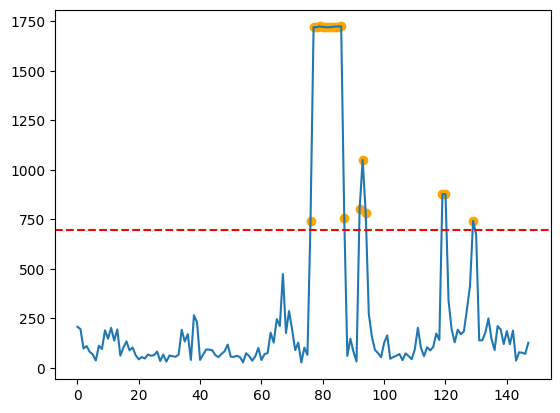

In [14]:
threshold = 10 * train_std + train_average

data_windows = np.lib.stride_tricks.sliding_window_view(trimmed_test_data[sensor_name],(window_size,))
test_distances = []
for window in data_windows[::jump_size]:
    minDist = 1e9
    for representative_window in representative_windows:
        dist = dynamic_time_warping(window[::sub_sampling_size], representative_window[::sub_sampling_size])
        if dist < minDist and dist != 0:
            minDist = dist
    test_distances.append(minDist)

plt.plot(test_distances)
above_threshold_indices = np.where(np.array(test_distances) > threshold)[0]
plt.scatter(above_threshold_indices, np.array(test_distances)[above_threshold_indices], color='orange', label='Above Threshold')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

To summarize our findings, we will also check the actual sensor data:

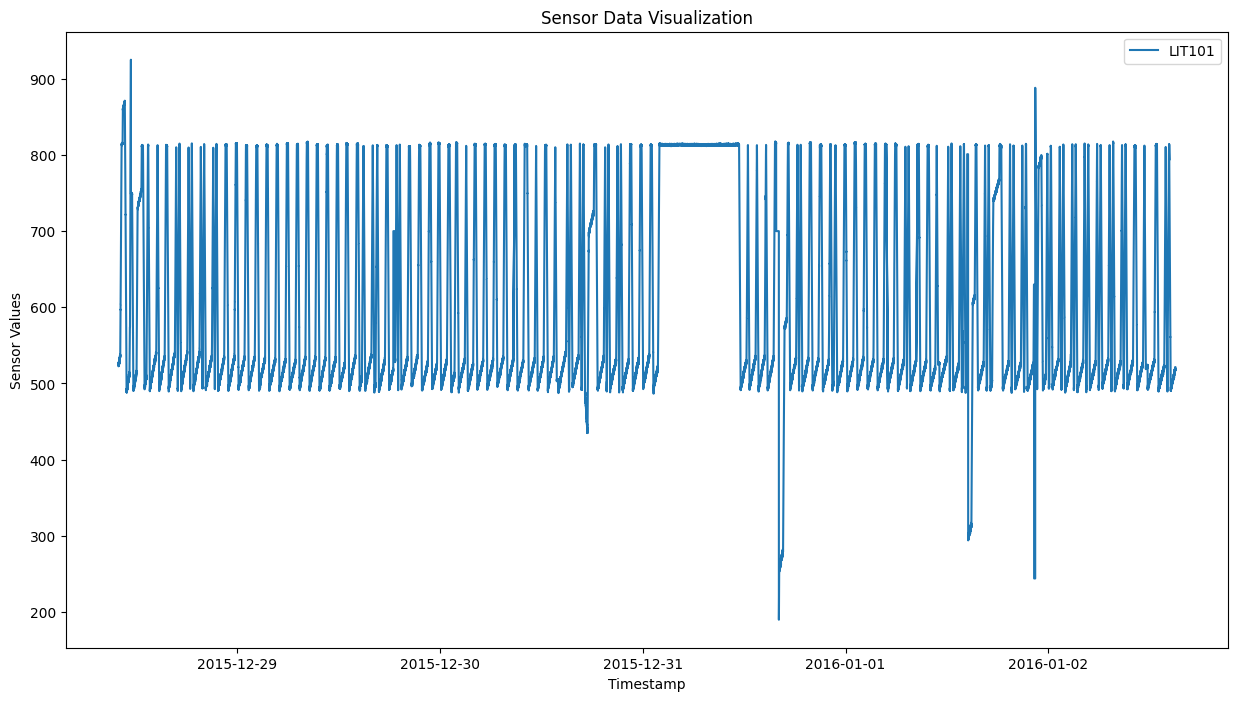

In [15]:
visualize_sensor_data(trimmed_test_data, sensors=['LIT101'])

# PCA-based anomaly detection

In [6]:
def principal_component_analysis(df, k):
    # print("___START_TEST____")
    cov_mat = df.cov()
    eigenvalues, eigenvectors = np.linalg.eigh(cov_mat) # each eigenvector is a column
    eigenvectors = eigenvectors.T # each eigenvector is a row
    # print(eigenvalues)
    # print(eigenvectors)
    sorted_eigenvectors = [x for _,x in sorted(zip(eigenvalues,eigenvectors), key=lambda pair: pair[0])]
    sorted_eigenvectors = sorted_eigenvectors[::-1]
    # print(sorted_eigenvectors)
    sorted_eigenvectors = sorted_eigenvectors[:k] # now we have list of the k-th most important eigenvectors
    sorted_matrix = np.stack( sorted_eigenvectors, axis=1) 
    # print(sorted_matrix)
    return sorted_matrix
    

def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))
    # print("___START_TEST____")
    # print(df - df.mean())
    projected_data = ( df - df.mean() ) @ eigenvectors # apparently we are supposed to do dimensionality reduced mean-shifted data
    # print(projected_data)
    return pd.DataFrame(projected_data)

In [11]:
number_of_sensors = train_data.shape[1] - 2 # 51
trimmed_train_data = train_data[17000:]
# print(train_data)
# print(trimmed_train_data)
only_sensor_train_data = train_data.drop(['Timestamp','Normal/Attack'], axis=1)

mean = only_sensor_train_data.mean()

pca_eigenvectors = principal_component_analysis(only_sensor_train_data, number_of_sensors)
new_df = apply_principal_component_analysis(only_sensor_train_data, pca_eigenvectors)
reconstructed_X = new_df @ (pca_eigenvectors.T)

reconstructed_with_mean = pd.DataFrame(data=reconstructed_X.values + mean.values, columns=only_sensor_train_data.columns)


(496800, 51)
(496800, 51)
(496800, 51)


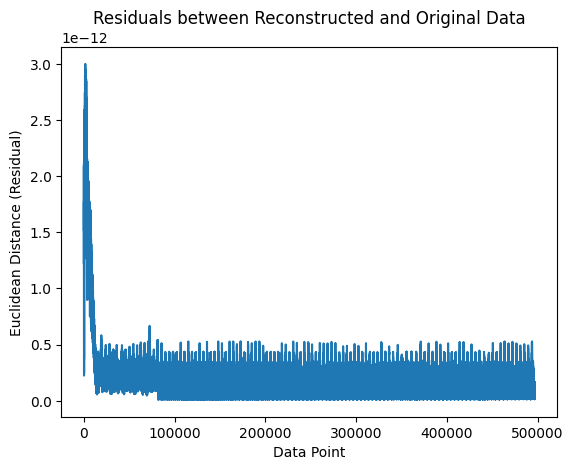

In [12]:
print(reconstructed_with_mean.shape)
print(only_sensor_train_data.shape)

diff = reconstructed_with_mean - only_sensor_train_data

print(diff.shape)
residuals = np.linalg.norm(diff, axis=1)

# print(residuals)

# Plot residuals
plt.plot(residuals)
plt.xlabel('Data Point')
plt.ylabel('Euclidean Distance (Residual)')
plt.title('Residuals between Reconstructed and Original Data')
plt.show()
